<a href="https://colab.research.google.com/github/Morgan11-tech/Capstone-Project/blob/main/capstone_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q --upgrade ipython
# !pip install -q --upgrade ipykernel
!pip install --upgrade torch
# !pip install --upgrade torch_geometric
# !pip install torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install --upgrade pandas
!pip install --upgrade matplotlib
!pip install --upgrade node2vec
!pip install --upgrade scikit-learn
!pip install torch-scatter
!pip install torch-sparse
# !pip install torch_sparse -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html
!pip install torch_geometric
# !pip install plotly==5.22.0

import torch_sparse
import pyg_lib
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import Node2Vec, FastRGCNConv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, average_precision_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.loader import GraphSAINTRandomWalkSampler
from torch_geometric.data import Data, NeighborSampler, GraphSAINTEdgeSampler
import networkx as nx
from gensim.models import Word2Vec
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import contains_isolated_nodes
from torch_sparse import SparseTensor
from tqdm import tqdm

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html


In [3]:
# !python --version

In [4]:
from google.colab import drive
# importing the dataset from google drive
drive.mount('/content/drive')


!ls '/content/drive/My Drive/ML'
data = pd.read_csv('/content/drive/My Drive/ML/kg.csv', low_memory=False)

# data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
evaluations.csv  kg.csv  results-bert.csv  submissions-bert.csv  train.json


In [5]:
data.query('y_type=="disease"|x_type=="disease"')

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
346728,contraindication,contraindication,15193,DB05271,drug,Rotigotine,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
346729,contraindication,contraindication,15193,DB05271,drug,Rotigotine,DrugBank,36035,1200_1134_15512_5080_100078,disease,hypertension,MONDO_grouped
346730,indication,indication,16687,DB00492,drug,Fosinopril,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
346731,indication,indication,16687,DB00492,drug,Fosinopril,DrugBank,36035,1200_1134_15512_5080_100078,disease,hypertension,MONDO_grouped
346732,contraindication,contraindication,14483,DB13956,drug,Estradiol valerate,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
...,...,...,...,...,...,...,...,...,...,...,...,...
6499510,exposure_disease,linked to,31393,11565,disease,metabolic syndrome X,MONDO,61825,D015032,exposure,Zinc,CTD
6499511,exposure_disease,linked to,28208,5148,disease,type 2 diabetes mellitus,MONDO,61825,D015032,exposure,Zinc,CTD
6499512,exposure_disease,linked to,84172,1076,disease,glucose intolerance,MONDO,61825,D015032,exposure,Zinc,CTD
6499513,exposure_disease,linked to,33063,100130,disease,adult acute respiratory distress syndrome,MONDO,61825,D015032,exposure,Zinc,CTD


### Data Preparation

In [6]:
# Filter rows where x_type is 'drug' and y_type is 'disease'
drug_disease_df = data[(data['x_type'] == 'drug') & (data['y_type'] == 'disease')]
drug_disease_df

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
346728,contraindication,contraindication,15193,DB05271,drug,Rotigotine,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
346729,contraindication,contraindication,15193,DB05271,drug,Rotigotine,DrugBank,36035,1200_1134_15512_5080_100078,disease,hypertension,MONDO_grouped
346730,indication,indication,16687,DB00492,drug,Fosinopril,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
346731,indication,indication,16687,DB00492,drug,Fosinopril,DrugBank,36035,1200_1134_15512_5080_100078,disease,hypertension,MONDO_grouped
346732,contraindication,contraindication,14483,DB13956,drug,Estradiol valerate,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
...,...,...,...,...,...,...,...,...,...,...,...,...
389354,indication,indication,16634,DB00036,drug,Coagulation factor VIIa Recombinant Human,DrugBank,27527,31332_100326_31009,disease,Glanzmann thrombasthenia,MONDO_grouped
389355,indication,indication,16634,DB00036,drug,Coagulation factor VIIa Recombinant Human,DrugBank,38622,2244,disease,factor VII deficiency,MONDO
389356,indication,indication,16634,DB00036,drug,Coagulation factor VIIa Recombinant Human,DrugBank,28673,9211,disease,congenital factor VII deficiency,MONDO
389357,contraindication,contraindication,18277,DB01202,drug,Levetiracetam,DrugBank,84334,1186,disease,depersonalization disorder,MONDO


In [7]:
# Extract triples (relationship in the form: subject, relation, object)
triples = drug_disease_df[['x_name','y_name','relation']]

# creating a dataframe of triples
triples_df = pd.DataFrame({'drug': triples['x_name'],
                           'disease': triples['y_name'],
                           'relation_type': triples['relation']
                          })
triples_df

,drug,disease,relation_type
346728,Rotigotine,hypertensive disorder,contraindication
346729,Rotigotine,hypertension,contraindication
346730,Fosinopril,hypertensive disorder,indication
346731,Fosinopril,hypertension,indication
346732,Estradiol valerate,hypertensive disorder,contraindication
...,...,...,...
389354,Coagulation factor VIIa Recombinant Human,Glanzmann thrombasthenia,indication
389355,Coagulation factor VIIa Recombinant Human,factor VII deficiency,indication
389356,Coagulation factor VIIa Recombinant Human,congenital factor VII deficiency,indication
389357,Levetiracetam,depersonalization disorder,contraindication


### Known disease associations for a given drug (will be used later for predictions)


In [8]:
drug_name = "Levetiracetam"
drug_triples = drug_disease_df[drug_disease_df['x_name'] == drug_name]

# get the indications and contraindications
indications = drug_triples[drug_triples['relation'] == 'indication']['y_name'].tolist()
contraindications = drug_triples[drug_triples['relation'] == 'contraindication']['y_name'].tolist()
off_label_use = drug_triples[drug_triples['relation'] == 'off-label use']['y_name'].tolist()

print(f"Drug: {drug_name}\n")
print(f"Indications: {indications}\n")
print(f"Contraindications: {contraindications}\n")
print(f"Off-label_use: {off_label_use}\n")

Drug: Levetiracetam

Indications: ['partial epilepsy']

Contraindications: ['anxiety disorder', 'neurotic disorder', 'dysthymic disorder', 'kidney disease', 'pyoureter', 'liver disease', 'gallbladder disease', 'psychotic disorder', 'schizophreniform disorder', 'mental disorder', 'schizoaffective disorder', 'neutropenia', 'agranulocytosis', 'leukopenia', 'pancytopenia', 'anxiety', 'depersonalization disorder']

Off-label_use: []



### Creating the graph using networkx


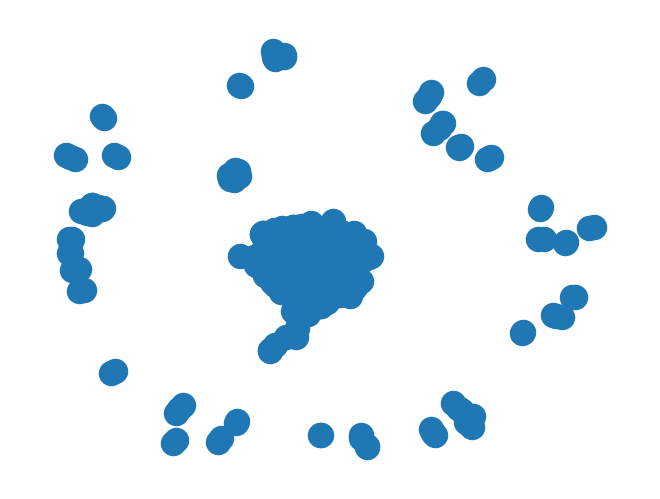

In [9]:
# Create a graph from the dataframe using networkx
G = nx.from_pandas_edgelist(triples_df, source='drug', target= 'disease', edge_attr= 'relation_type')

nx.draw(G, with_labels=False)

# import plotly.graph_objs as go
# import networkx as nx

# G = nx.from_pandas_edgelist(triples_df, source='drug', target='disease', edge_attr='relation_type')
# pos = nx.spring_layout(G)



### Encoding the drugs and disease nodes using Node2vec algorithm


In [10]:
from scipy.linalg import triu
from node2vec import Node2Vec

# Training the model on the graph
node2vec = Node2Vec(G, dimensions=50, walk_length=10, num_walks=100, workers=3)
my_model = node2vec.fit(window=10,min_count=1)

# Obtaining drug and disease names
drugs = list(triples_df['drug'])
diseases = list(triples_df['disease'])

Computing transition probabilities:   0%|          | 0/4128 [00:00<?, ?it/s]

In [11]:
# create a mapping for drugs and diseases - basically giving each unique drug and disease a unique index
# we will use it for the edge_index

drug_mapping = {drug:idx for idx,drug in enumerate(set(drugs))}
disease_mapping = {disease:idx + len(drug_mapping) for idx, disease in enumerate(set(diseases))}
# disease_mapping

In [12]:
# create a mapping for drugs and diseases - basically giving each unique drug and disease a unique index
# we will use it for the edge_index

drug_mapping = {drug:idx for idx,drug in enumerate(set(drugs))}
disease_mapping = {disease:idx + len(drug_mapping) for idx, disease in enumerate(set(diseases))}
# disease_mapping

In [13]:
# Embeddings - learning low dimensional representations of nodes and converting to a tensor
all_nodes = list(set(drugs+diseases))
node_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in all_nodes]

In [14]:
# Combining the embeddings into a single tensor (our node feature tensor for pytorch geometric)
x = torch.stack(node_embeddings,dim=0)
x

tensor([[ 0.0260, -0.1960,  0.0391,  ..., -0.3008,  0.4007, -0.1471],
        [-0.0615, -0.2126,  0.9432,  ..., -0.3898, -0.4924,  0.2490],
        [-0.3235,  0.3553,  0.1804,  ...,  0.0654,  0.2612, -0.3932],
        ...,
        [ 0.1440,  0.3169, -0.5451,  ..., -0.3433,  0.4622, -0.2746],
        [-0.2266, -0.7591,  0.2070,  ..., -0.8511, -0.1214,  0.5351],
        [ 0.0045,  0.2164,  0.1106,  ...,  0.0369, -0.0234, -0.1508]])

In [15]:
# Creating the edge_index tensor
source = [drug_mapping[row['drug']]for _, row in triples_df.iterrows()]
destination = [disease_mapping[row['disease']]for _, row in triples_df.iterrows()]

edge_index = torch.tensor([source,destination],dtype=torch.long)
edge_index

tensor([[1518, 1518,  963,  ...,  309,  278, 1793],
        [2788, 2628, 2788,  ..., 2651, 3758, 3012]])

In [16]:
# Creating the edge_attr tensor -  since there are only two relation types, indication and contraindication:
# we have 0 and 1 respectively

relation_map = {'indication':0, 'contraindication':1, 'off-label use': 2}
edge_attr = torch.tensor([relation_map[row['relation_type']]for _,row in triples_df.iterrows()])
edge_attr

tensor([1, 1, 0,  ..., 0, 1, 0])

In [17]:
# Obtain the unique relation types from the dataframe
unique_relations = triples_df['relation_type'].unique()

# Map relation types to indices
relation_type_mapping = {relation_type: idx for idx, relation_type in enumerate(unique_relations)}

# Map relation types to indices for each edge in edge_index
edge_type = torch.tensor([relation_type_mapping[relation_type] for relation_type in unique_relations], dtype=torch.long)


# Repeat the edge_type tensor to match the number of edges
edge_type = edge_type.repeat(42631 // len(unique_relations) + 1)[:42631]
edge_type.shape

torch.Size([42631])

In [18]:
edge_index_arr = torch.arange(edge_index.shape[1])

# Training and testing sets
train_edge_index, val_edge_index = train_test_split(edge_index_arr, test_size=0.2, random_state=42)

# creating boolean masks based on the indicies from train_test_split
train_mask, val_mask = torch.zeros_like(edge_index_arr).bool(),torch.zeros_like(edge_index_arr).bool()
train_mask[train_edge_index] = 1
val_mask[val_edge_index] = 1

train_mask,val_mask


(tensor([False, False,  True,  ...,  True,  True,  True]),
 tensor([ True,  True, False,  ..., False, False, False]))

In [19]:
# Creating pytorch geometric data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_type=edge_type, train_mask=train_mask,val_mask=val_mask)
data

Data(x=[4128, 50], edge_index=[2, 42631], edge_attr=[42631], edge_type=[42631], train_mask=[42631], val_mask=[42631])

In [20]:
data.test_neg_mask = negative_sampling(data.edge_index, num_neg_samples=data.val_mask.sum())


## Preparing the model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Building the Graph neural network model

In [22]:
# Relational Graph Convolutional Network Model
class RGCN(torch.nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, num_relations):
        super(RGCN, self).__init__()
        self.num_relations = num_relations
        self.conv1 = FastRGCNConv(in_dim, h_dim, num_relations, aggr='mean')
        self.conv2 = FastRGCNConv(h_dim, out_dim, num_relations, aggr='mean')
        self.relu = nn.ReLU()
        self.w_rels = nn.Parameter(torch.Tensor(num_relations, out_dim))
        nn.init.xavier_uniform_(self.w_rels, gain=nn.init.calculate_gain('relu'))

    def forward(self, x, edge_index, edge_type):
        x1 = self.conv1(x, edge_index, edge_type)
        x1 = self.relu(x1)
        x2 = self.conv2(x1, edge_index, edge_type)
        out = F.log_softmax(x2, dim=1)

        return out

def get_metrics(model, embed, edge_index, edge_type, labels):
    probs = DistMult(embed, edge_index, edge_type, model)
    loss = F.binary_cross_entropy(probs, labels)
    probs = probs.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return loss, probs, labels

def DistMult(embed, edge_index, edge_type, model):
    s = embed[edge_index[0, :]]
    o = embed[edge_index[1, :]]
    r = model.w_rels[edge_type]
    scores = torch.sum(s * r * o, dim=1)
    return torch.sigmoid(scores)

def get_link_labels(edge_index_pos_len, edge_index_neg_len):
    link_labels = torch.zeros(edge_index_pos_len + edge_index_neg_len).float().to(device)
    link_labels[:int(edge_index_pos_len)] = 1.
    return link_labels

def get_embeddings(data):
    data = data.to(device)
    x = data.x
    edge_index_pos = data.edge_index
    edge_type = torch.squeeze(data.edge_type)
    embed = model(x, edge_index_pos, edge_type)

    return embed

In [23]:
# Initializing the model
# data.x.size(1)
model = RGCN(in_dim=data.x.size(1), h_dim=64, out_dim=64, num_relations=len(unique_relations)).to(device)
model

RGCN(
  (conv1): FastRGCNConv(50, 64, num_relations=3)
  (conv2): FastRGCNConv(64, 64, num_relations=3)
  (relu): ReLU()
)

In [24]:
# define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)

In [25]:
data.x = data.x.to(torch.float)
data.edge_index = data.edge_index.to(torch.long)
data.edge_attr = data.edge_attr.to(torch.long)
data.edge_type = data.edge_type.to(torch.long)

In [26]:
# Sampling fully connected subgraphs for training
# import torch_geometric.utils as tg_utils

# data.edge_index = data.edge_index.to(torch.long)

# data.adj = tg_utils.to_dense_adj(data)


# data_loader = NeighborLoader(
#     data,
#     num_neighbors=[15, 10],  # One entry per layer
#     batch_size=50,
#     input_nodes=None,  # To be set dynamically for train, val, test
# )
data_loader = GraphSAINTRandomWalkSampler(data, batch_size=50, walk_length=6, num_steps=12)
# data_loader

In [27]:
num_relations=len(unique_relations)
num_relations

3

Data types in the Data object:
x: torch.float32
edge_index: torch.int64
edge_attr: torch.int64
edge_type: torch.int64
train_mask: torch.bool
val_mask: torch.bool
test_neg_mask: torch.int64
Epoch: 1 | train loss: 4.38 | train auroc: 0.49 | train acc: 0.49 |
Epoch: 1 | val loss: 3.10 | val auroc: 0.49 | val acc: 0.49 |
----------------------------------------------------------------------------------------------
Epoch: 2 | train loss: 1.39 | train auroc: 0.65 | train acc: 0.61 |
Epoch: 2 | val loss: 1.42 | val auroc: 0.62 | val acc: 0.58 |
----------------------------------------------------------------------------------------------
Epoch: 3 | train loss: 1.03 | train auroc: 0.72 | train acc: 0.67 |
Epoch: 3 | val loss: 1.16 | val auroc: 0.69 | val acc: 0.63 |
----------------------------------------------------------------------------------------------
Epoch: 4 | train loss: 0.87 | train auroc: 0.75 | train acc: 0.70 |
Epoch: 4 | val loss: 0.97 | val auroc: 0.73 | val acc: 0.67 |
------

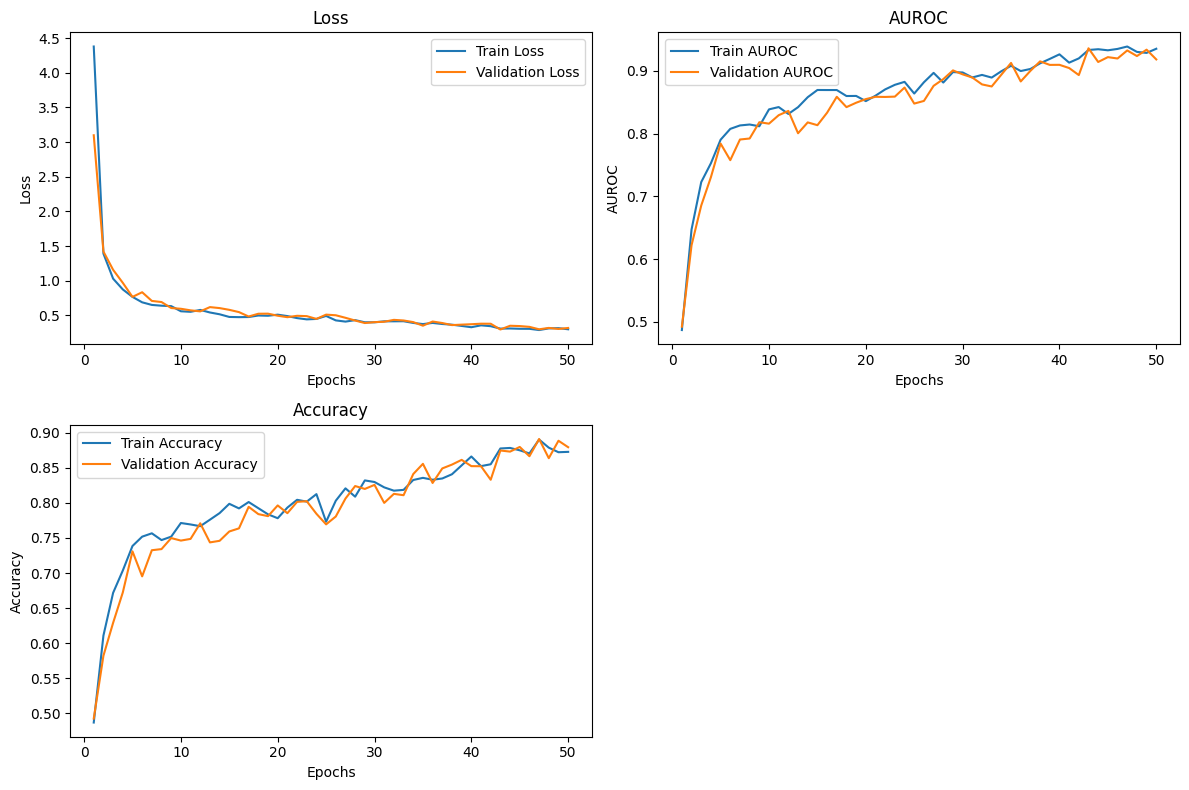

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def train(data, embed):
    data = data.to(device)
    x = data.x
    edge_index_train_pos = data.edge_index[:, data.train_mask]
    edge_type_train = torch.squeeze(data.edge_type[data.train_mask])
    edge_index_train_neg = negative_sampling(edge_index_train_pos, num_neg_samples=data.train_mask.sum())
    edge_index_train_total = torch.cat([edge_index_train_pos, edge_index_train_neg], dim=-1)
    edge_type_train_total = torch.cat([edge_type_train, edge_type_train[:edge_index_train_neg.size(1)]], dim=-1)
    link_labels = get_link_labels(edge_index_train_pos.size(1), edge_index_train_neg.size(1))
    loss, probs, labels = get_metrics(model, embed, edge_index_train_total, edge_type_train_total, link_labels)
    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)

    labels = torch.tensor(labels, device=device, dtype=torch.long)
    probs = torch.tensor(probs, device=device)

    # Calculate accuracy
    predictions = (probs > 0.5)  # Threshold the predictions
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total

    loss_epoch_train.append(loss.item())
    auroc_epoch_train.append(auroc)
    acc_epoch_train.append(accuracy)  # Store accuracy for train

    loss.backward()
    optimizer.step()

@torch.no_grad()
def validation(data, embed, evaluate_rel=False):
    data = data.to(device)
    x = data.x
    edge_index_val_pos = data.edge_index[:, data.val_mask]
    edge_type_val = torch.squeeze(data.edge_type[data.val_mask])
    edge_index_val_neg = negative_sampling(edge_index_val_pos, num_neg_samples=data.val_mask.sum())
    edge_index_val_total = torch.cat([edge_index_val_pos, edge_index_val_neg], dim=-1)
    edge_type_val_total = torch.cat([edge_type_val, edge_type_val[:edge_index_val_neg.size(1)]], dim=-1)
    link_labels = get_link_labels(edge_index_val_pos.size(1), edge_index_val_neg.size(1))
    loss, probs, labels = get_metrics(model, embed, edge_index_val_total, edge_type_val_total, link_labels)
    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)

    labels = torch.tensor(labels, device=device, dtype=torch.long)
    labels = labels.cpu()
    probs = torch.tensor(probs, device=device)
    probs = probs.cpu()

    # Calculate accuracy
    predictions = (probs > 0.5)  # Thresholding the predictions
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total

    edge_type_val_total = edge_type_val_total.detach().cpu()
    loss_epoch_val.append(loss.item())
    auroc_epoch_val.append(auroc)
    acc_epoch_val.append(accuracy)  # Store accuracy for validation

    if not evaluate_rel:
        return

    for i in range(num_relations):
        mask = (edge_type_val_total == i)
        if mask.sum() == 0:
            continue
        probs_per_rel = probs[mask]
        labels_per_rel = labels[mask]
        auroc_per_rel = roc_auc_score(labels_per_rel, probs_per_rel)
        auroc_edge_type[i].append(auroc_per_rel)

loss_train_total, loss_val_total = [], []
auroc_train_total, auroc_val_total = [], []
acc_train_total, acc_val_total = [], []  # Lists to store overall accuracy

print("Data types in the Data object:")
for key, value in data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.dtype}")

for epoch in range(0, 50):
    loss_epoch_train, loss_epoch_val = [], []
    auroc_epoch_train, auroc_epoch_val = [], []
    acc_epoch_train, acc_epoch_val = [], []  # Lists to store epoch accuracy

    for batch in data_loader:
        optimizer.zero_grad()
        model.train()
        embed = get_embeddings(batch)
        train(batch, embed)

        model.eval()
        validation(batch, embed)

    loss_train_total.append(np.mean(loss_epoch_train))
    auroc_train_total.append(np.mean(auroc_epoch_train))
    acc_train_total.append(np.mean(acc_epoch_train))  # Store overall accuracy

    loss_val_total.append(np.mean(loss_epoch_val))
    auroc_val_total.append(np.mean(auroc_epoch_val))
    acc_val_total.append(np.mean(acc_epoch_val))  # Store overall accuracy

    print('Epoch: {} | train loss: {} | train auroc: {} | train acc: {} |'.format(
        epoch + 1, "%.2f" % np.mean(loss_epoch_train), "%.2f" % np.mean(auroc_epoch_train),
        "%.2f" % np.mean(acc_epoch_train)))
    print('Epoch: {} | val loss: {} | val auroc: {} | val acc: {} |'.format(
        epoch + 1, "%.2f" % np.mean(loss_epoch_val), "%.2f" % np.mean(auroc_epoch_val),
        "%.2f" % np.mean(acc_epoch_val)))
    print('----------------------------------------------------------------------------------------------')

# Plotting
epochs = range(1, len(loss_train_total) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, loss_train_total, label='Train Loss')
plt.plot(epochs, loss_val_total, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, auroc_train_total, label='Train AUROC')
plt.plot(epochs, auroc_val_total, label='Validation AUROC')
plt.title('AUROC')
plt.xlabel('Epochs')
plt.ylabel('AUROC')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, acc_train_total, label='Train Accuracy')
plt.plot(epochs, acc_val_total, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
edge_type_mapping= {
    0: 'indications',
    1: 'contraindications',
    2: 'off-label use'
}

### Classifying relation types for each edge

In [30]:
auroc_edge_type = {relations:[] for relations in range(num_relations)}

for batch in data_loader:
  embed = get_embeddings(batch)
  validation(batch,embed,evaluate_rel=True)

for relations, values in auroc_edge_type.items():
  print('auroc for relation type {}: {}'.format(edge_type_mapping[relations], "%.3f"% np.mean(values)))

auroc for relation type indications: 0.946
auroc for relation type contraindications: 0.933
auroc for relation type off-label use: 0.936


# Predicting novel drug associations

In [31]:
# Separate drugs and diseases
drug_nodes = set(drugs)
disease_nodes = set(diseases)

# Creating drug and disease embeddings
drug_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in drug_nodes]
disease_embeddings = [torch.tensor(my_model.wv[node], dtype=torch.float) for node in disease_nodes]

# Normalize the embeddings
drug_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in drug_embeddings]
disease_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in disease_embeddings]


drug_embedding = torch.stack(drug_embeddings, dim=0)
disease_embedding = torch.stack(disease_embeddings, dim=0)


def get_predicted_relation(disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses):
    indications_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[drug_indications.index(indication)], dim=0) for indication in drug_indications]
    contraindications_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[drug_contraindications.index(contraindication)], dim=0) for contraindication in drug_contraindications]
    off_label_similarities = [torch.cosine_similarity(disease_embedding, disease_embedding[drug_off_label_uses.index(off_label)], dim=0) for off_label in drug_off_label_uses]

    max_indication_sim = max(indications_similarities, default=0.0)
    max_contraindication_sim = max(contraindications_similarities, default=0.0)
    max_off_label_sim = max(off_label_similarities, default=0.0)

    max_sim = max(max_indication_sim, max_contraindication_sim, max_off_label_sim)

    if max_sim == max_indication_sim:
        return 'Indication'
    elif max_sim == max_contraindication_sim:
        return 'Contraindication'
    else:
        return 'Off-label use'

def find_novel_associations(drug_name, drug_embedding, disease_embeddings, drug_indications, drug_contraindications, drug_off_label_uses, top_k=10):
    known_diseases = set(drug_indications + drug_contraindications + drug_off_label_uses)
    similarities = {}
    for i, disease_embedding in enumerate(disease_embeddings):
        disease_id = list(disease_nodes)[i]
        if disease_id not in known_diseases:
            # Option 1: Take the max of the tensor
            similarity = torch.cosine_similarity(drug_embedding, disease_embedding, dim=0).max().item()

            similarities[disease_id] = similarity

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    potential_associations = []
    for disease_id, score in sorted_similarities[:top_k]:
        disease_embedding = disease_embeddings[list(disease_nodes).index(disease_id)]
        predicted_relation = get_predicted_relation(disease_embedding, drug_indications, drug_contraindications, drug_off_label_uses)
        potential_associations.append((disease_id, score, predicted_relation))
    return potential_associations


drug_name = "Bupropion"
drug_triples = drug_disease_df[drug_disease_df['x_name'] == drug_name]

# get the indications and contraindications
indications = drug_triples[drug_triples['relation'] == 'indication']['y_name'].tolist()
contraindications = drug_triples[drug_triples['relation'] == 'contraindication']['y_name'].tolist()
drug_off_label_uses = drug_triples[drug_triples['relation'] == 'off-label use']['y_name'].tolist()

novel_associations = find_novel_associations(drug_name, drug_embedding, disease_embeddings, indications, contraindications, drug_off_label_uses)

print(f"Drug: {drug_name}")
print("Potential Novel Associations:")
for i, (disease_id, score, predicted_relation) in enumerate(novel_associations, start=1):
    print(f"{i}. {disease_id} (Score: {score:.2f}, Predicted: {predicted_relation})")


<ipython-input-31-0b16fe647780>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drug_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in drug_embeddings]
<ipython-input-31-0b16fe647780>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  disease_embeddings = [F.normalize(torch.tensor(emb, dtype=torch.float), p=2, dim=0) for emb in disease_embeddings]


Drug: Bupropion
Potential Novel Associations:
1. methemoglobinemia due to deficiency of methemoglobin reductase (Score: 0.87, Predicted: Indication)
2. Crimean-Congo hemorrhagic fever (Score: 0.87, Predicted: Indication)
3. neuromyelitis optica (Score: 0.87, Predicted: Contraindication)
4. malignant glioma (Score: 0.87, Predicted: Indication)
5. hereditary hypophosphatemic rickets (Score: 0.87, Predicted: Indication)
6. neurohypophyseal diabetes insipidus (Score: 0.87, Predicted: Contraindication)
7. high bone mass osteogenesis imperfecta (Score: 0.87, Predicted: Contraindication)
8. diffuse large B-cell lymphoma of the central nervous system (Score: 0.87, Predicted: Indication)
9. malignant germ cell tumor of ovary (Score: 0.87, Predicted: Contraindication)
10. intracranial arteriosclerosis (Score: 0.87, Predicted: Indication)
